# Champion Challenger Serving

Lots of ways to set it up - this particular setup will perform inferencing for champion and challenger models in parallel and return a response for both

### Setup MLRun Project

In [1]:
import mlrun
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
project = mlrun.get_or_create_project("model-serving-champion-challenger", "./")

> 2023-04-03 19:13:09,507 [info] Created and saved project model-serving-champion-challenger: {'from_template': None, 'overwrite': False, 'context': './', 'save': True}
> 2023-04-03 19:13:09,508 [info] created project model-serving-champion-challenger and saved in MLRun DB


### Define Model Class, Router, and Transformations

In [5]:
%%writefile champion_challenger.py
from typing import List

import numpy as np
import storey
from cloudpickle import load

import mlrun
from mlrun.serving.routers import ParallelRun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model(".pkl")
        self.model = load(open(model_file, "rb"))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body["inputs"])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

class ParallelRouter(ParallelRun):
        
    def merger(self, body, results):
        """Merging logic
        input the event body and a dict of route results and returns a dict with merged results
        
        Incoming results dictionary will look like:
        results = {
            'champion': {'id': '12f9d8b5317b444fa3773ff6d96d3ebe', 'model_name': 'sepal_length_cm', 'outputs': [0, 2]},
            'challenger': {'id': '12f9d8b5317b444fa3773ff6d96d3ebe', 'model_name': 'petal_width_cm', 'outputs': [0, 2]}
        }
        
        Merged result will look like:
        merged = {
            'champion': [0, 2],
            'challenger': [0, 2]
        }
        """
        print()
        print("Merger in:", results)
        merged = {result["model_name"] : result["outputs"] for result in results.values()}
        print("Merger out:", merged)
        return merged

Writing champion_challenger.py


### Define Graph

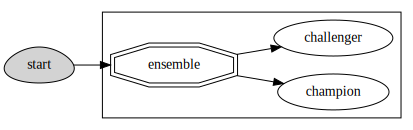

In [6]:
fn = project.set_function(
    name="model-server", func="champion_challenger.py", 
    kind="serving", image="mlrun/mlrun"
)
graph = fn.set_topology("flow", engine="async")

router = graph.add_step("*ParallelRouter", name="ensemble").respond()
router.add_route("champion", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")
router.add_route("challenger", class_name="ClassifierModel", model_path="https://s3.wasabisys.com/iguazio/models/iris/model.pkl")

graph.plot(rankdir="LR")

### Test Locally

In [7]:
mock_server = fn.to_mock_server()

> 2023-04-03 19:14:17,096 [info] model champion was loaded
> 2023-04-03 19:14:17,388 [info] model challenger was loaded
> 2023-04-03 19:14:17,389 [info] Loaded ['champion', 'challenger']


In [8]:
body = {
    "inputs" : [
        [5.4, 3.9, 1.3, 0.4],
        [6.9, 3.1, 5.1, 2.3],
        [6.7, 2.5, 5.8, 1.8],
        [5.5, 2.3, 4.0, 1.3],
        [4.6, 3.4, 1.4, 0.3]
    ]
}

In [9]:
mock_server.test("", body=body)


Merger in: {'challenger': {'id': 'b37007f0fb9548a481288daf872fbb26', 'model_name': 'challenger', 'outputs': [0, 2, 2, 1, 0]}, 'champion': {'id': 'b37007f0fb9548a481288daf872fbb26', 'model_name': 'champion', 'outputs': [0, 2, 2, 1, 0]}}
Merger out: {'challenger': [0, 2, 2, 1, 0], 'champion': [0, 2, 2, 1, 0]}


{'challenger': [0, 2, 2, 1, 0], 'champion': [0, 2, 2, 1, 0]}

### Deploy on K8s

In [10]:
fn.deploy()

> 2023-04-03 19:14:27,760 [info] Starting remote function deploy
2023-04-03 19:14:28  (info) Deploying function
2023-04-03 19:14:28  (info) Building
2023-04-03 19:14:28  (info) Staging files and preparing base images
2023-04-03 19:14:28  (info) Building processor image
2023-04-03 19:15:33  (info) Build complete
2023-04-03 19:15:43  (info) Function deploy complete
> 2023-04-03 19:15:43,620 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-model-serving-champion-challenger-model-server.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['model-serving-champion-challenger-model-server-model-s-m2fekbiz.default-tenant.app.us-sales-350.iguazio-cd1.com/']}


'http://model-serving-champion-challenger-model-server-model-s-m2fekbiz.default-tenant.app.us-sales-350.iguazio-cd1.com/'

In [11]:
fn.invoke("", body=body)

> 2023-04-03 19:15:52,402 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-model-serving-champion-challenger-model-server.default-tenant.svc.cluster.local:8080/'}


{'challenger': [0, 2, 2, 1, 0], 'champion': [0, 2, 2, 1, 0]}